# Финальный проект

<a id='section_id'></a>
## Содержание

[Шаг 1. Загрузка данных](#section_id1)

[Шаг 2. Предобработка данных](#section_id2)

[Шаг 3. Исследовательский анализ данных](#section_id3)

[Шаг 4. Подготовка данных](#section_id4)

[Шаг 5. Обучение моделей](#section_id5)

[Шаг 6. Общий вывод](#section_id6)

## Описание исследования

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

## Цель исследования

- Обучить модель машинного обучения для решения задачи бинарной классификации по предсказанию оттока клиентов

## Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл **contract_new.csv**:
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл **personal_new.csv**:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл **internet_new.csv**:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл **phone_new.csv**:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

## Ход исследования

1. Получение данных
2. Предобработка данных
3. Исследовательский анализ
4. Подготовка данных
5. Обучение моделей
6. Выводы

## Импорт библиотек

In [1]:
# установка библиотек
!pip install phik -q
!pip install category_encoders -q
!pip install shap -q

In [2]:
# импорт библиотек

# работа с данными
import pandas as pd
import numpy as np

# работа с графикой
from matplotlib import pyplot as plt
import seaborn as sns

# анализ признаков
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# инструменты подготовки данных и машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# пайплайны
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# импорт метрик
from sklearn.metrics import roc_auc_score, confusion_matrix

# импорт инструментов анализа
import shap

## Задание констант

In [3]:
# задание констант
RANDOM_STATE = 100225
TEST_SIZE = 0.25

<a id='section_id1'></a>
## Шаг 1. Загрузка данных
[к содержанию](#section_id)

In [4]:
# загрузка данных
try:
    # попытка загрузки локальных файлов
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    # загрузка данных через интернет
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [5]:
# корректировка названий столбцов в соответствии с "хорошим стилем"
def make_snake(header):
    '''Функция принимает на вход заголовок и возвращает их snake_case варианты'''
    result = ''
    
    # поставить перед всеми словами нижнее подчеркивание
    for i, letter in enumerate(header):
        if letter.isupper() and header[i-1].isupper():
            result += letter.lower()
        elif letter.isupper():
            result += '_' + letter.lower()
        else:
            result += letter
            
    # удалить нижнее подчеркивание в начале слова
    if result[0] == '_':
        result = result[1:]
        
    return result

In [6]:
# корректировка названий столбцов
contract.columns = [make_snake(header) for header in contract.columns]
personal.columns = [make_snake(header) for header in personal.columns]
internet.columns = [make_snake(header) for header in internet.columns]
phone.columns = [make_snake(header) for header in phone.columns]

In [7]:
# задание индекс столбца для каждого датасета
contract = contract.set_index('customer_id')
personal = personal.set_index('customer_id')
internet = internet.set_index('customer_id')
phone = phone.set_index('customer_id')

In [8]:
# функция для обзора данных
def preview(dataset):
    '''Функция принимает на вход набор данных и выводит основную информацию о нем.'''
    display(dataset.head())
    dataset.info()
    display(dataset.describe(include='all').T)

In [9]:
# обзор данных о контрактах
preview(contract)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customer_id,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
begin_date,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
total_charges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# обзор персональных данных
preview(personal)

,gender,senior_citizen,partner,dependents
customer_id,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# обзор данных по интернет услугам
preview(internet)

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customer_id,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_tv       5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


,count,unique,top,freq
internet_service,5517,2,Fiber optic,3096
online_security,5517,2,No,3498
online_backup,5517,2,No,3088
device_protection,5517,2,No,3095
tech_support,5517,2,No,3473
streaming_tv,5517,2,No,2810
streaming_movies,5517,2,No,2785


In [12]:
# обзор данных по телефон услугам
preview(phone)

,multiple_lines
customer_id,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


,count,unique,top,freq
multiple_lines,6361,2,No,3390


In [13]:
# объединение данных в один датафрейм по индексу customer_id
df = pd.concat([contract, personal, internet, phone], axis=1, join='outer')

<a id='section_id2'></a>
## Шаг 2. Предобработка данных
[к содержанию](#section_id)

In [14]:
preview(df)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
begin_date,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
end_date,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
total_charges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Приведение типов данных

In [15]:
# приведение типов данных столбца begin_date
try:
    df['begin_date'] = pd.to_datetime(df['begin_date'])
except:
    print('Проблемы приведением дат')

In [16]:
# приведение типов данных столбца end_date
try:
    df['end_date'] = pd.to_datetime(df['end_date'])
except:
    print('Проблемы с приведением дат')

Проблемы с приведением дат


In [17]:
# изучение столбца с конечной датой
df['end_date'].value_counts()

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-12-01       2
2015-04-01       2
2014-10-01       1
2014-06-01       1
2014-11-01       1
Name: end_date, Length: 67, dtype: int64

- Присутствует значения No, которые означают, что клиент не расторг контракт. Не будем изменять данные значения для получения целевого признака в дальнейшем

In [18]:
# приведение типов данных столбца total_charges
try:
    df['total_charges'] = pd.to_numeric(df['total_charges'])
except:
    print('Проблемы с приведением чисел')

Проблемы с приведением чисел


In [19]:
# изучение столбца total_charges
df['total_charges'].value_counts()

          11
20.45      6
101.0      5
255.0      4
1007.5     4
          ..
288.9      1
219.02     1
393.75     1
2679.6     1
931.8      1
Name: total_charges, Length: 6658, dtype: int64

Присутствуют 11 значений с символом пробела вместо суммы расходов

In [20]:
# изучение данных с символом пробела в столбце суммы расходов
df[df['total_charges'] == ' ']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


- Все эти клиенты заключили договор в 1 февраля 2020 года, значит их полные расходы равны месячным расходам. Копируем значения из столбца monthly_charges в столбец total_charges и установим тип данных float64

In [21]:
# копирование значений в столбец total_charges и приведение типов данных
df.loc[df['total_charges']==' ', 'total_charges'] = df.loc[df['total_charges']==' ', 'monthly_charges']
df['total_charges'] = pd.to_numeric(df['total_charges'])

### Анализ пропусков

In [22]:
# анализ пропусков
df.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

- Если клиент не пользуется интернет услугами, то у него в столбцах internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies будут пропуски, которые логично заменить значениями No.
- В случае, если клиент не пользуется телефонией, то в столбце multiple_lines будут пропуски, которые также логично заменить значениями No.

In [23]:
# замена пропусков значениями No
df = df.fillna('No')

### Анализ дубликатов

In [24]:
# анализ полных дубликатов
df.duplicated().sum()

4

In [25]:
# просмотр полных дубликатов
df[df.duplicated(keep=False)]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
4376-KFVRS,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2866-IKBTM,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,No,No,No,No,No,No,No,No
4312-KFRXN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80,Male,0,Yes,No,No,No,No,No,No,No,No,Yes
8605-ITULD,2020-01-01,No,Month-to-month,No,Mailed check,19.55,19.55,Female,0,No,No,No,No,No,No,No,No,No,No
0673-IGUQO,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,No,No,No,No,No,No,No,No
2668-TZSPS,2020-01-01,No,Month-to-month,No,Mailed check,20.45,20.45,Male,0,No,No,No,No,No,No,No,No,No,No
3892-NXAZG,2014-02-01,No,Two year,Yes,Credit card (automatic),114.05,8211.60,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
8774-GSBUN,2014-02-01,No,Two year,No,Mailed check,25.40,1828.80,Male,0,Yes,No,No,No,No,No,No,No,No,Yes


- Дубликаты строк имеют разные индексы с идентификатором клиента, не будем исключать эти данные

<a id='section_id3'></a>
## Шаг 3. Исследовательский анализ данных
[к содержанию](#section_id)

In [26]:
# исследование признаков
display(df.describe(include='all', datetime_is_numeric=True).T)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
begin_date,7043,NaN,NaN,NaN,2017-04-30 13:01:50.918642688,2013-10-01 00:00:00,2015-06-01 00:00:00,2017-09-01 00:00:00,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN
end_date,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
paperless_billing,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_method,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
monthly_charges,7043.0,NaN,NaN,NaN,64.761692,18.25,35.5,70.35,89.85,118.75,30.090047
total_charges,7043.0,NaN,NaN,NaN,2115.377573,19.05,436.75,1343.35,3236.69,9221.38,2112.678861
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
senior_citizen,7043.0,NaN,NaN,NaN,0.162147,0.0,0.0,0.0,0.0,1.0,0.368612
partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Не рассматриваемые признаки:
- **begin_date** - не рассматриваем данный признак
- **end_date** - не рассматриваем данный признак, признак будет использован для создания целевого

Количественные признаки, используем масштабирование:
- **monthly_charges** 
- **total_charges**

Категориальные признаки, используем кодирование:
- **type**
- **paperless_billing**
- **payment_method**
- **gender**
- **senior_citizen**
- **partner**
- **dependents**
- **internet_service**
- **online_security**
- **online_backup**
- **device_protection**
- **tech_support**
- **streaming_tv**
- **streaming_movies**
- **multiple_lines**

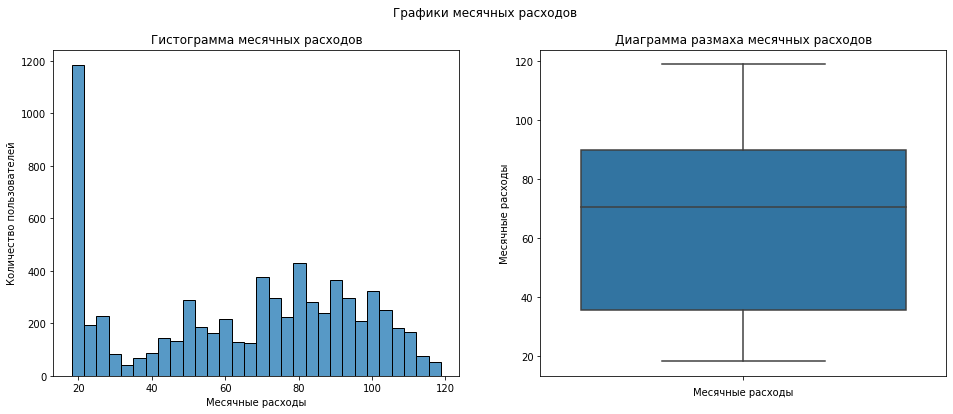

In [27]:
# графики месячных расходов
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle('Графики месячных расходов')
sns.histplot(x=df['monthly_charges'], bins=30, ax=ax[0])
sns.boxplot(y=df['monthly_charges'], ax=ax[1])
ax[0].set_title('Гистограмма месячных расходов')
ax[0].set_xlabel('Месячные расходы')
ax[0].set_ylabel('Количество пользователей')
ax[1].set_title('Диаграмма размаха месячных расходов')
ax[1].set_ylabel('Месячные расходы')
ax[1].set_xlabel('Месячные расходы')
plt.show()

- Более 1000 пользователей имеют минимальные месячные расходы от 20 до 30 ед. стоимости. Распределение остальной выборки напоминает нормальное. Возможно, достаточно большую часть пользователей устраивают услуги за эту стоимость, или в какой-то период времени проводилась промо акция.

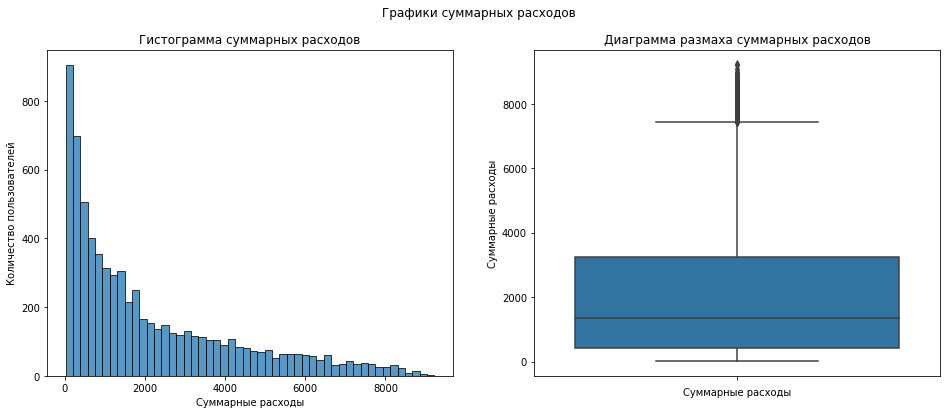

In [28]:
# гистограмма суммарных расходов
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle('Графики суммарных расходов')
sns.histplot(x=df['total_charges'], bins=50, ax=ax[0])
sns.boxplot(y=df['total_charges'], ax=ax[1])
ax[0].set_title('Гистограмма суммарных расходов')
ax[0].set_xlabel('Суммарные расходы')
ax[0].set_ylabel('Количество пользователей')
ax[1].set_title('Диаграмма размаха суммарных расходов')
ax[1].set_ylabel('Суммарные расходы')
ax[1].set_xlabel('Суммарные расходы')
plt.show()

In [29]:
# проверка длительности контрактов клиентов
df[df['total_charges'] >= 6000]['begin_date']

customer_id
8091-TTVAX   2015-04-01
9959-WOFKT   2014-03-01
5248-YGIJN   2014-02-01
8769-KKTPH   2014-11-01
5067-XJQFU   2014-08-01
                ...    
0218-QNVAS   2014-03-01
7203-OYKCT   2014-02-01
1035-IPQPU   2014-11-01
2234-XADUH   2014-02-01
3186-AJIEK   2014-08-01
Name: begin_date, Length: 544, dtype: datetime64[ns]

- Распределение суммарных расходов напоминает экспоненциальное. Существуют пользователи, расходы которых очень высоки, превышают 6000 ед. стоимости. Это старые клиенты, контракты которых заключены более 5 лет назад
- Определим, каких клиентов больше среди расторгнувших контракт: с высокими или низкими месячными и суммарными расходами

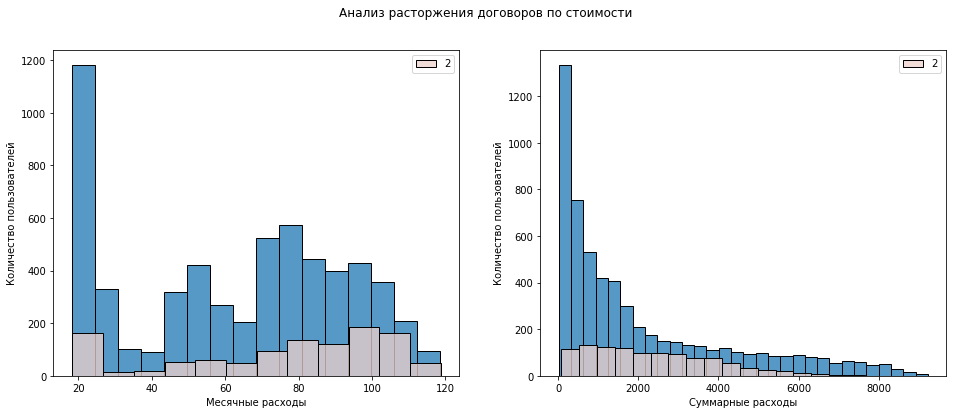

In [30]:
# построим гистограмму месячных расходов, с разделением расторжению договора
still = df[df['end_date'] == 'No']
gone = df[df['end_date'] != 'No']

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
fig.suptitle('Анализ расторжения договоров по стоимости')
# месячные расходы
sns.histplot(x=still['monthly_charges'], hue=0, ax=ax[0])
sns.histplot(x=gone['monthly_charges'], hue=2, ax=ax[0])
ax[0].set_xlabel('Месячные расходы')
ax[0].set_ylabel('Количество пользователей')
# суммарные расходы
sns.histplot(x=still['total_charges'], hue=0, ax=ax[1])
sns.histplot(x=gone['total_charges'], hue=2, ax=ax[1])
ax[1].set_xlabel('Суммарные расходы')
ax[1].set_ylabel('Количество пользователей')
plt.show()

- Среди ушедших клиентов выделяется сдвинутый вправо пик, т.е. большее значение суммарных расходов
- Среди ушедших также сдвинуто вправо среднее значение месячных расходов
- Получается компания теряет клиентов, которые приносили большие суммарные доходы (старые клиенты) и клиентов, которые приносили сравнительно больший доход каждый месяц

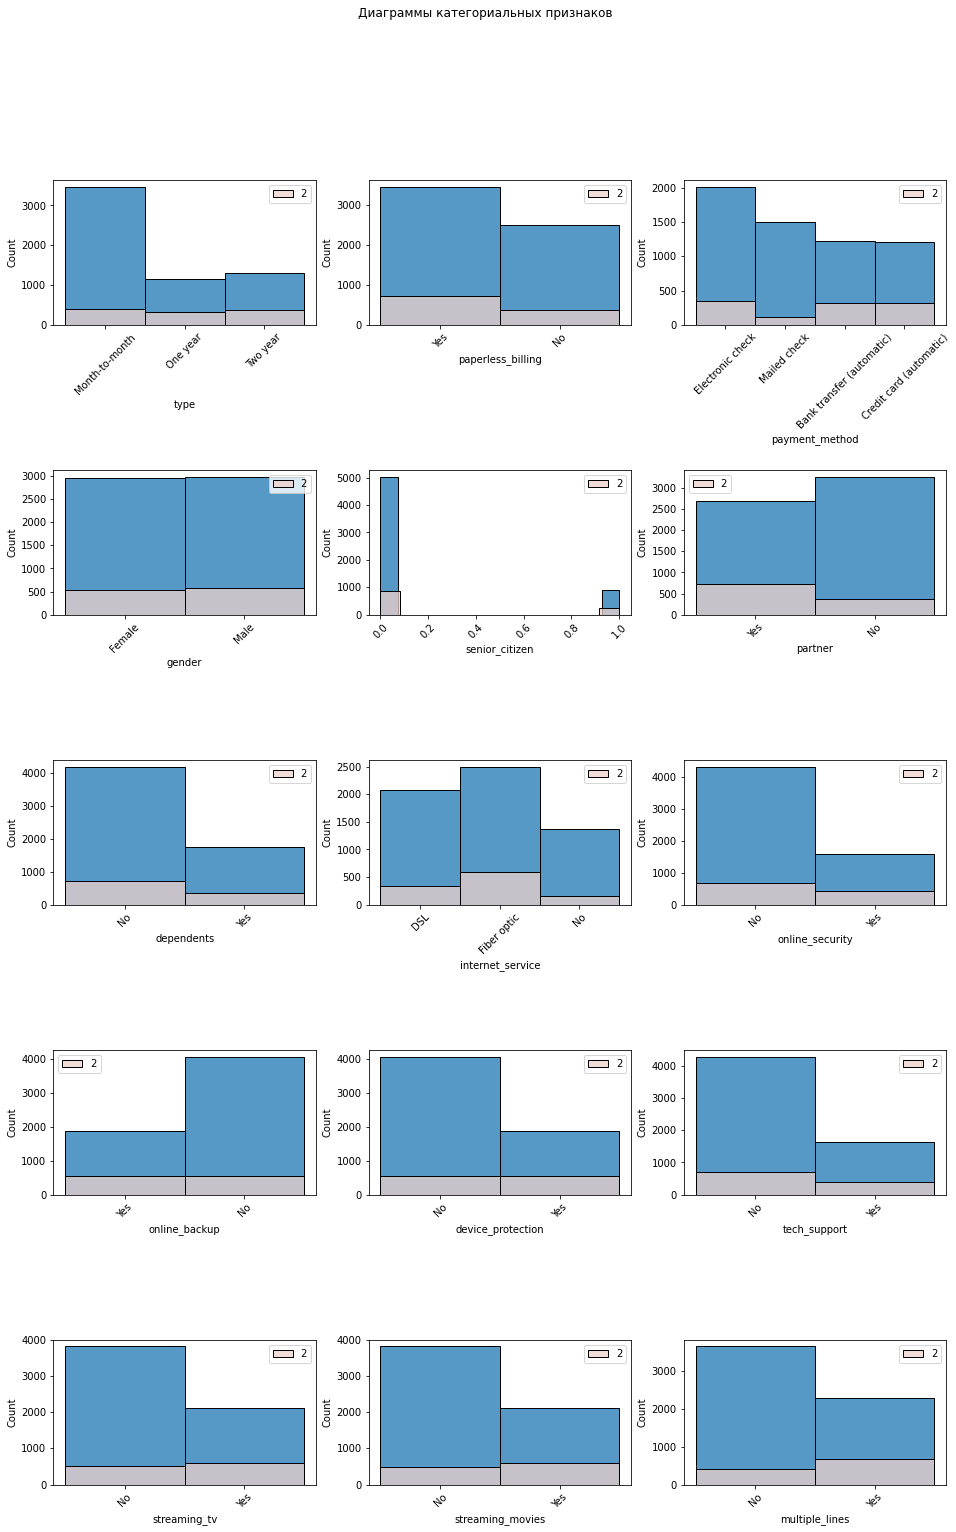

In [31]:
# диаграммы категориальных признаков
cat_cols = ['type',
    'paperless_billing',
    'payment_method',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'multiple_lines']

fig, ax = plt.subplots(ncols=3, nrows=5, figsize=(16, 24))
fig.subplots_adjust(wspace=0.2, hspace=1.0)
fig.suptitle('Диаграммы категориальных признаков')
for i, col in enumerate(cat_cols):
    ax[i//3, i%3].tick_params(axis='x', rotation=45)
    sns.histplot(x=still[col], hue=0, ax=ax[i//3, i%3])
    sns.histplot(x=gone[col], hue=2, ax=ax[i//3, i%3])
plt.show()

- Большая часть клиентов не является пенсионерами, использует месячную подписку, не пользуется дополнительными интернет услугами и предпочитает вариант оплаты онлайн
- Среди ушедших клиентов больше пенсионеров, тех, кто пользовался streaming_tv, streaming_movies и multiple_lines
- Создадим целевой признак на основе столбцов begin_date и end_date для оценки влияния признаков на отток клиентов.
- Будем обозначать отток 1, сохранение договора 0

### Создание признаков

In [32]:
# создание целевого признака
df['gone'] = np.where(df['end_date'] == 'No', 1, 0)

In [33]:
# создание дополнительного признака длителности заключенного договора
# добавление столбца
df['end'] = np.where(df['end_date'] == 'No', '2020-01-01', df['end_date'])

# приведение типа
try:
    df['end'] = pd.to_datetime(df['end'])
except:
    print('Ошибка приведения типа даты')

# вычисление длительности контракта
try:
    df['duration'] = (df['end'] - df['begin_date']).dt.days
except:
    print('Ошибка приведения типа числа')
    
# удаление лишних признаков из датафрейма
df = df.drop(['end', 'begin_date', 'end_date'], axis=1)

### Корреляционный анализ

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'gone', 'duration']


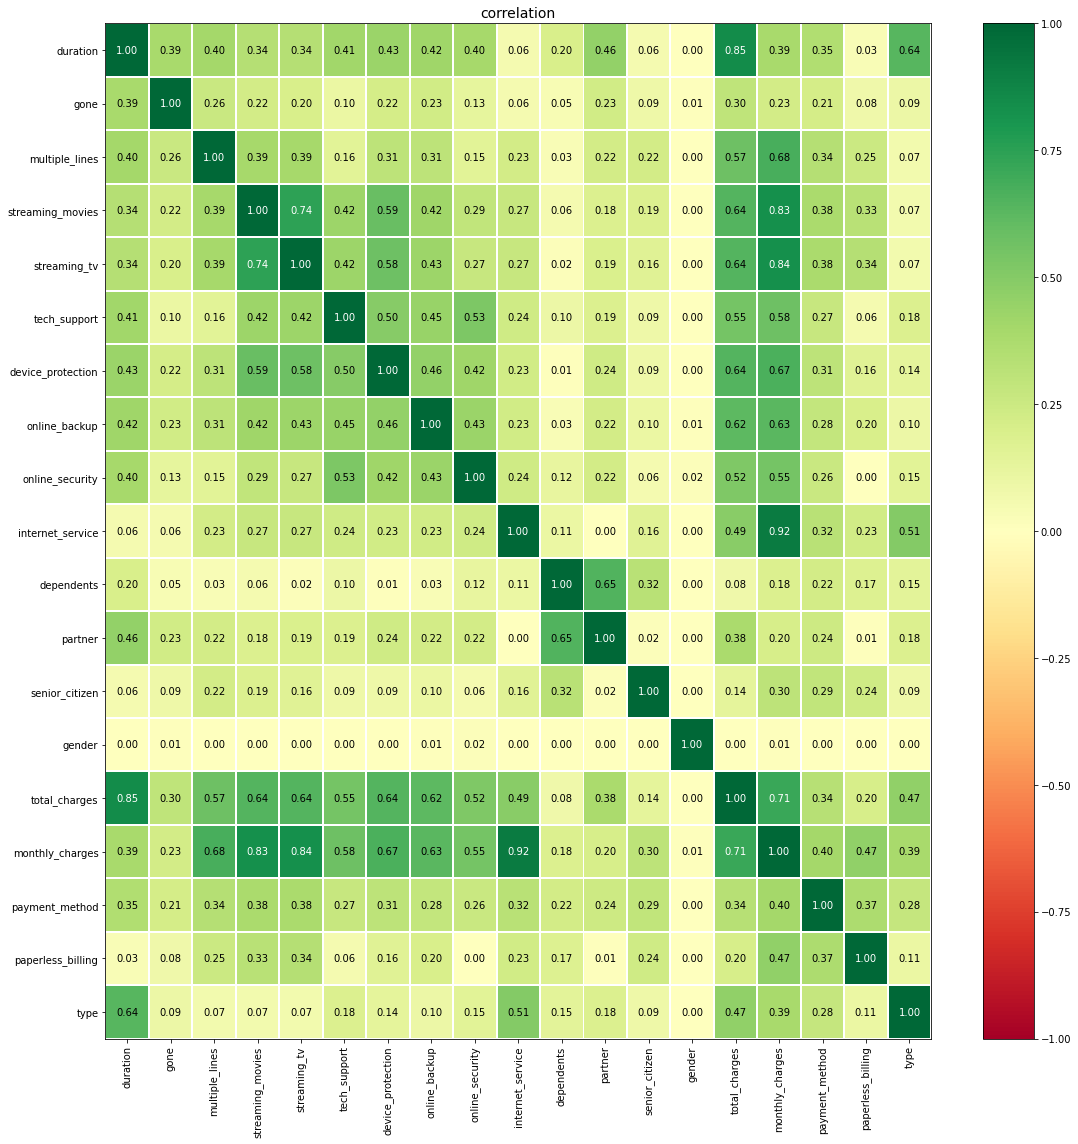

In [34]:
# анализ корреляционных зависимостей между признаками
phik_overview = df.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(16, 16)
)

- Сильнее всего коррелируют с целевым признаком gone признаки: duration, total_charges, multiple_lines
- Слабее всего с целевым коррелируют признаки: gender, dependents, internet_service. Отбросим данные признаки для уменьшения размерности
- Признак internet_service сильно коррелирует с monthly_charges, коэффициент корреляции 0.92. Отбросим этот признак из рассмотрения

In [35]:
# удаление лишних признаков
df = df.drop(['internet_service', 'gender', 'dependents'], axis=1)

<a id='section_id4'></a>
## Шаг 4. Подготовка данных
[к содержанию](#section_id)

In [36]:
# разделение данных на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['gone'], axis=1),
    df['gone'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

X_train.shape, X_test.shape

((5282, 15), (1761, 15))

In [37]:
# списки столбцов для обработки
num_columns = ['monthly_charges',
               'total_charges',
               'duration']
cat_columns = ['type',
               'paperless_billing',
               'payment_method',
               'partner', 
               'online_security',
               'online_backup', 
               'device_protection',
               'tech_support',
               'streaming_tv',
               'streaming_movies',
               'multiple_lines']
no_change = ['senior_citizen']

In [38]:
# пайплайн для кодирования категориальных признаков
te_pipe = Pipeline(
    [('te', TargetEncoder())]
    )

In [39]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('te', te_pipe, cat_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [40]:
# итоговый пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier())
])

In [41]:
# задание параметров для пайплайна
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 8),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(4, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LightGBM()
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)],
        'models__max_depth': [2, 5],
        'models__learning_rate': [1.0, 10.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

<a id='section_id5'></a>
## Шаг 5. Обучение моделей
[к содержанию](#section_id)

In [42]:
# инициализация подбора параметров
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [43]:
%%time
# запуск подбора параметров
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te',
                                                  Pipeline(steps=[('te',
                                                                   TargetEncoder())]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'partner',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'multiple_lines']),
             

### Анализ результатов обучения

In [44]:
# получение результатов
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__min_samples_leaf,param_models__min_samples_split,param_preprocessor__num,param_models__n_neighbors,param_models__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
118,0.379800,0.061283,0.077818,0.041519,"LGBMClassifier(learning_rate=1.0, max_depth=2,...",2,NaN,NaN,MinMaxScaler(),NaN,1.0,"{'models': LGBMClassifier(learning_rate=1.0, m...",0.873393,0.871063,0.869163,0.876851,0.836517,0.865397,0.014666,1
117,0.311428,0.037587,0.095189,0.034206,"LGBMClassifier(learning_rate=1.0, max_depth=2,...",2,NaN,NaN,StandardScaler(),NaN,1.0,"{'models': LGBMClassifier(learning_rate=1.0, m...",0.853880,0.861463,0.862123,0.871125,0.847323,0.859183,0.008065,2
119,0.363157,0.029678,0.075327,0.039655,"LGBMClassifier(learning_rate=1.0, max_depth=2,...",2,NaN,NaN,passthrough,NaN,1.0,"{'models': LGBMClassifier(learning_rate=1.0, m...",0.842173,0.863285,0.869163,0.869057,0.841732,0.857082,0.012536,3
120,0.843544,0.151246,0.109149,0.008574,"LGBMClassifier(learning_rate=1.0, max_depth=2,...",5,NaN,NaN,StandardScaler(),NaN,1.0,"{'models': LGBMClassifier(learning_rate=1.0, m...",0.855699,0.860607,0.852566,0.859672,0.841289,0.853967,0.006962,4
121,0.730436,0.074240,0.078693,0.042105,"LGBMClassifier(learning_rate=1.0, max_depth=2,...",5,NaN,NaN,MinMaxScaler(),NaN,1.0,"{'models': LGBMClassifier(learning_rate=1.0, m...",0.844895,0.850932,0.740625,0.848944,0.844193,0.825918,0.042720,5
122,0.746358,0.076940,0.106621,0.008349,"LGBMClassifier(learning_rate=1.0, max_depth=2,...",5,NaN,NaN,passthrough,NaN,1.0,"{'models': LGBMClassifier(learning_rate=1.0, m...",0.844922,0.840243,0.740625,0.836104,0.733958,0.799170,0.050645,6
16,0.165934,0.003836,0.023286,0.000200,DecisionTreeClassifier(random_state=100225),5,2,4,MinMaxScaler(),NaN,NaN,{'models': DecisionTreeClassifier(random_state...,0.787990,0.805687,0.792378,0.784527,0.781589,0.790434,0.008433,7
15,0.167378,0.001132,0.023170,0.000585,DecisionTreeClassifier(random_state=100225),5,2,4,StandardScaler(),NaN,NaN,{'models': DecisionTreeClassifier(random_state...,0.787990,0.805687,0.792378,0.784527,0.781589,0.790434,0.008433,7
14,0.169995,0.002494,0.022727,0.000211,DecisionTreeClassifier(random_state=100225),5,2,3,passthrough,NaN,NaN,{'models': DecisionTreeClassifier(random_state...,0.787990,0.805687,0.792378,0.784527,0.781589,0.790434,0.008433,7
13,0.184610,0.011473,0.024867,0.000760,DecisionTreeClassifier(random_state=100225),5,2,3,MinMaxScaler(),NaN,NaN,{'models': DecisionTreeClassifier(random_state...,0.787990,0.805687,0.792378,0.784527,0.781589,0.790434,0.008433,7


- Лучше всего с задачей справилась модель LGBMClassifier(learning_rate=1.0, max_depth=2, random_state=100225) с использванием MinMaxScaler для количественных признаков и TargetEncoder для категориальных.

In [45]:
# расчет метрики на тестовой выборке
probabilities = grid_search.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.89659216608067


- Метрика roc_auc на тестовой выборке удовлетворяет условию задачи

In [46]:
# создание списка названий столбцов после трансформации
transformer_columns = list(grid_search.best_estimator_.named_steps['preprocessor']
     .named_transformers_['te']
     .named_steps['te']
     .get_feature_names_out()) \
+ num_columns + no_change

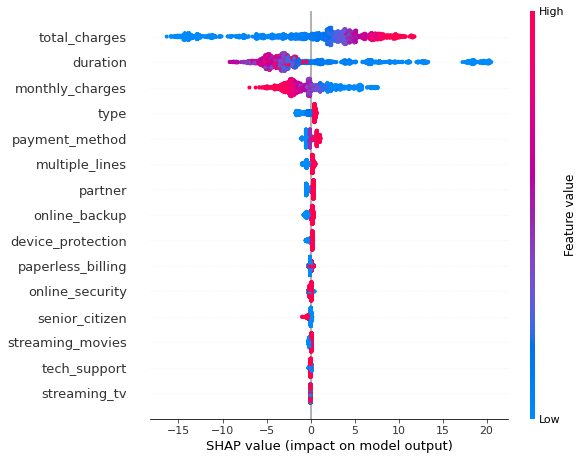

In [47]:
# построение графика важности признаков модели на основе shap
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train, y_train)
explainer = shap.Explainer(grid_search.best_estimator_.named_steps['models'], X_train_2)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
X_test_2 = pd.DataFrame(X_test_2, columns=transformer_columns)

shap_values = explainer(X_test_2, check_additivity=False)

shap.plots.beeswarm(shap_values[:,:], max_display=20) 

- Модель определила значимость признаков таким образом, что подвердилось предположение с этапа корреляционного анализа. Признаки total_charges, duration сильнее всего коррелируют с целевым признаком оттока клиентов. Также в пятерку лидеров по влиянию на целевой признак попали признаки monthly_charges, type, payment_method.
- Чем больше total_charges (суммарные расходы), тем больше вероятность оттока клиента
- Чем меньше duration (длительность контракта) и monthly_charges (ежемесячные расходы), тем меньше вероятность оттока клиента

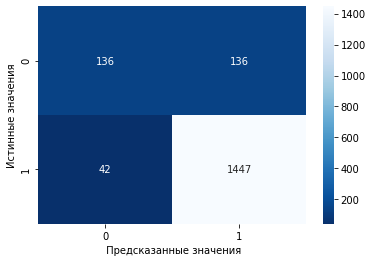

In [48]:
# получение предсказаний лучшей модели
y_pred = grid_search.best_estimator_.predict(X_test)

# построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
ax.set(xlabel=' Предсказанные значения', ylabel='Истинные значения')
plt.show()

- Ошибок первого рода (FP значений) - 136 
- Ошибок второго рода (FN значений) - 136
- Корректных TP значений - 1447
- Корректных TN значений - 42

В случае если необходимо обеспечить минимальный отток, т.е. классифицировать как можно больше потенциальных клиентов, которые могут расторгнуть контракт, и к примеру провести промо-акцию, следует снизить порог классификации, тем самым уменьшив количество FN, увеличив метрику recall. В случае, если необходимо провести точечную работу с клиентами, которые точно уйдут, необходимо уменьшать FP, увеличивать метрику precision, увеличивая порог классификации.

<a id='section_id6'></a>
## Шаг 6. Общий вывод
[к содержанию](#section_id)

В результате работы была построена модель машинного обучения для решения задачи классфикации оттока клиентов телекоммуникационной компании:
1. Была произведена **загрузка данных** и **предобработка данных**: данные, полученные из разных источников, были объединены, пропуски в данных были заполнены значениями No для указания на отсутствие информации. Пропуски в суммарных расходах были заполнены значениями месячных расходов так как контракты клиентов были заключены в месяц сбора данных. Целевой признак получен из столбца end_date, путем определения наличия даты расторжения договора. Клиенты, расторгнувшие договор были помечены 1, оставшиеся 0.
2. **Исследовательский анализ** показал различия по признакам среди клиентов, которые расторгли договор, и теми, кто этого не сделал. Среди ушедших клиентов наблюдается большее значение суммарных расходов и месячных расходов. Было выдвинуто предположение, что уходят старые клиенты, т.е. клиенты с длительным сроком обсуживания. Было принято решение добавить признак длительности заключенного договора duration (разница в днях дат расторжения и заключения договора). В результуте корреляционного анализа выяснили, что сильнее всего коррелируют с целевым признаком признаки длительности и суммарных расходов. Также была обнаружена мультиколинеарность признаков internet_service и monthly_charges, которая была устранена удалением internet_service. Также были отброшены признаки, слабо коррелирующие с целевым: gender и dependents.
3. На этапе **подготовки данных** были определены методы обработки столбцов для передачи в модель машинного обучения. Были определены пайплайны, и выбраны параметры моделей. Параметры подбирались с помощью гиперпараметрического поиска с кросс-валидацией GridSearchCV. Поиск должен был подобрать MinMaxScaler или StandardScaler для количественных признаков, гиперпараметры для DecisionTreeClassifier, KNighborsClassifier, LGBMClassifier
4. В результате **обучения моделей** методом гиперпараметрического поиска была определена лучшая модель LGBMClassifier(learning_rate=1.0, max_depth=2, random_state=100225) с использванием MinMaxScaler для количественных признаков и TargetEncoder для категориальных. Модель показала метрику roc_auc 0.865 на тренировочной выборке и 0.897 на тестовой. Модель обучалась на признаках:

- количественные признаки (MinMaxScaler): 'monthly_charges', 'total_charges', 'duration'
- категориальные признаки (TargetEncoder): 'type', 'paperless_billing', 'payment_method', 'partner', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines'
- признаки без изменений: 'senior_citizen' 

Для модели оказались наиболее важными признаки: total_charges, duration, monthly_charges, type, payment_method.

5. Рекомендации заказчику: в случае если необходимо обеспечить минимальный отток, т.е. классифицировать как можно больше потенциальных клиентов, которые могут расторгнуть контракт, и, к примеру, провести промо-акцию, следует снизить порог классификации, тем самым уменьшив количество FN, увеличив метрику recall. В случае, если необходимо провести точечную работу с клиентами, которые точно уйдут, необходимо уменьшать FP, увеличивать метрику precision, увеличивая порог классификации.